<a href="https://colab.research.google.com/github/suveer-dhawan/rock-paper-scissors/blob/main/RockPaperScissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rock Paper Scissors**

This Jupyter Notebook documents the process of building and training a Convolutional Neural Network (CNN) from scratch for the classic Rock Paper Scissors hand gesture classification task.

#Project Goal

The primary objective of this project is to develop a deep learning model capable of accurately identifying Rock, Paper, and Scissors gestures from image data. This involves:

- Data Preprocessing: Preparing the raw image dataset for model consumption.

- CNN Architecture Design: Constructing a custom convolutional neural network tailored for image feature extraction and classification.

- Model Training: Training the CNN on a diverse dataset of hand gestures.

- Performance Evaluation: Assessing the model's accuracy and generalization capabilities on unseen test images.

In this notebook, we will walk through the essential steps of a deep learning project:

1. Loading and Exploring Data: Understanding the structure and characteristics of the Rock Paper Scissors dataset.

2. Implementing Data Augmentation: Applying various transformations to the training images to enhance model robustness and prevent overfitting.

3. Defining a Custom CNN: Building a multi-layered CNN using PyTorch's ```nn.Module``` and ```nn.Sequential``` for efficient feature learning.

4. Setting up the Training Loop: Configuring the optimizer, loss function, and the training process to iterate through epochs.

5. Evaluating Model Performance: Monitoring training progress and evaluating the final model on a dedicated test set to gauge its real-world effectiveness.

This project serves as a practical exercise in applying fundamental deep learning concepts to a common image classification problem.

## Kaggle and Dataset Setup

To start, we are first creating the Kaggle API to link our notebook and ensure that we can easily upload of our dataset.

In [2]:
from google.colab import files
import os

# Check if credentials exist, if not, upload them
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your kaggle.json file:")
    uploaded = files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Credentials uploaded successfully!")
else:
    print("Kaggle credentials already exist!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Credentials uploaded successfully!


Next, we install our Rock Paper Scissors dataset from Kaggle.

In [3]:
# Kaggle API setup
!pip install kaggle
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle'

# Dataset download
!kaggle datasets download -d sanikamal/rock-paper-scissors-dataset
!unzip -q rock-paper-scissors-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset
License(s): other
 93% 421M/452M [00:07<00:00, 51.7MB/s]
100% 452M/452M [00:07<00:00, 64.5MB/s]


## Understanding the Data

Now we import the libraries we will need. We want to analyze our dataset and get an idea of how it is structured.

In [4]:
# Core PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms

# Additional libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# For data loading and preprocessing
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.datasets import ImageFolder

# For progress tracking and model summary
from tqdm import tqdm
from torchsummary import summary

In [5]:
# Looking inside the main dataset folder
!ls -la Rock-Paper-Scissors/

# Check the train folder structure
!ls -la Rock-Paper-Scissors/train/

# Count images per class - this is crucial for understanding class balance
print("Images per class:")
for class_name in ['rock', 'paper', 'scissors']:
    count = len(os.listdir(f'Rock-Paper-Scissors/train/{class_name}'))
    print(f"{class_name}: {count} images")

total 20
drwxr-xr-x 5 root root 4096 Jul 18 11:48 .
drwxr-xr-x 1 root root 4096 Jul 18 11:48 ..
drwxr-xr-x 5 root root 4096 Jul 18 11:48 test
drwxr-xr-x 5 root root 4096 Jul 18 11:48 train
drwxr-xr-x 2 root root 4096 Jul 18 11:48 validation
total 120
drwxr-xr-x 5 root root  4096 Jul 18 11:48 .
drwxr-xr-x 5 root root  4096 Jul 18 11:48 ..
drwxr-xr-x 2 root root 36864 Jul 18 11:48 paper
drwxr-xr-x 2 root root 36864 Jul 18 11:48 rock
drwxr-xr-x 2 root root 36864 Jul 18 11:48 scissors
Images per class:
rock: 840 images
paper: 840 images
scissors: 840 images


This tells us that the dataset is robustly structured with 840 images each (rock, paper, scissors) with no class imbalance
* ✅ Pre-split dataset: train/test/validation folders already provided
* ✅ Great size: 2,520 training images total (840 × 3)

In [6]:
# Let's get the working dataset summary
print("Working Dataset Summary:")
print("-" * 40)

train_total = 2520
test_total = 372
total_images = train_total + test_total

print(f"Training images: {train_total}")
print(f"Testing images: {test_total}")
print(f"Total images: {total_images}")
print(f"Train/Test split: {train_total/total_images:.1%} / {test_total/total_images:.1%}")

Working Dataset Summary:
----------------------------------------
Training images: 2520
Testing images: 372
Total images: 2892
Train/Test split: 87.1% / 12.9%


We observe the summary of our working dataset which shows our data is well balanced. The test folder will serve as our final evaluation set with 372 images to test our model's accuracy.

## Examples

Next, we want to look at a sample of our dataset to see what kinds of images are included. We look at the 1st image in each class [rock, paper, scissors] for both our training and testing subsets.

We also want to see the image dimensions for the dataset.

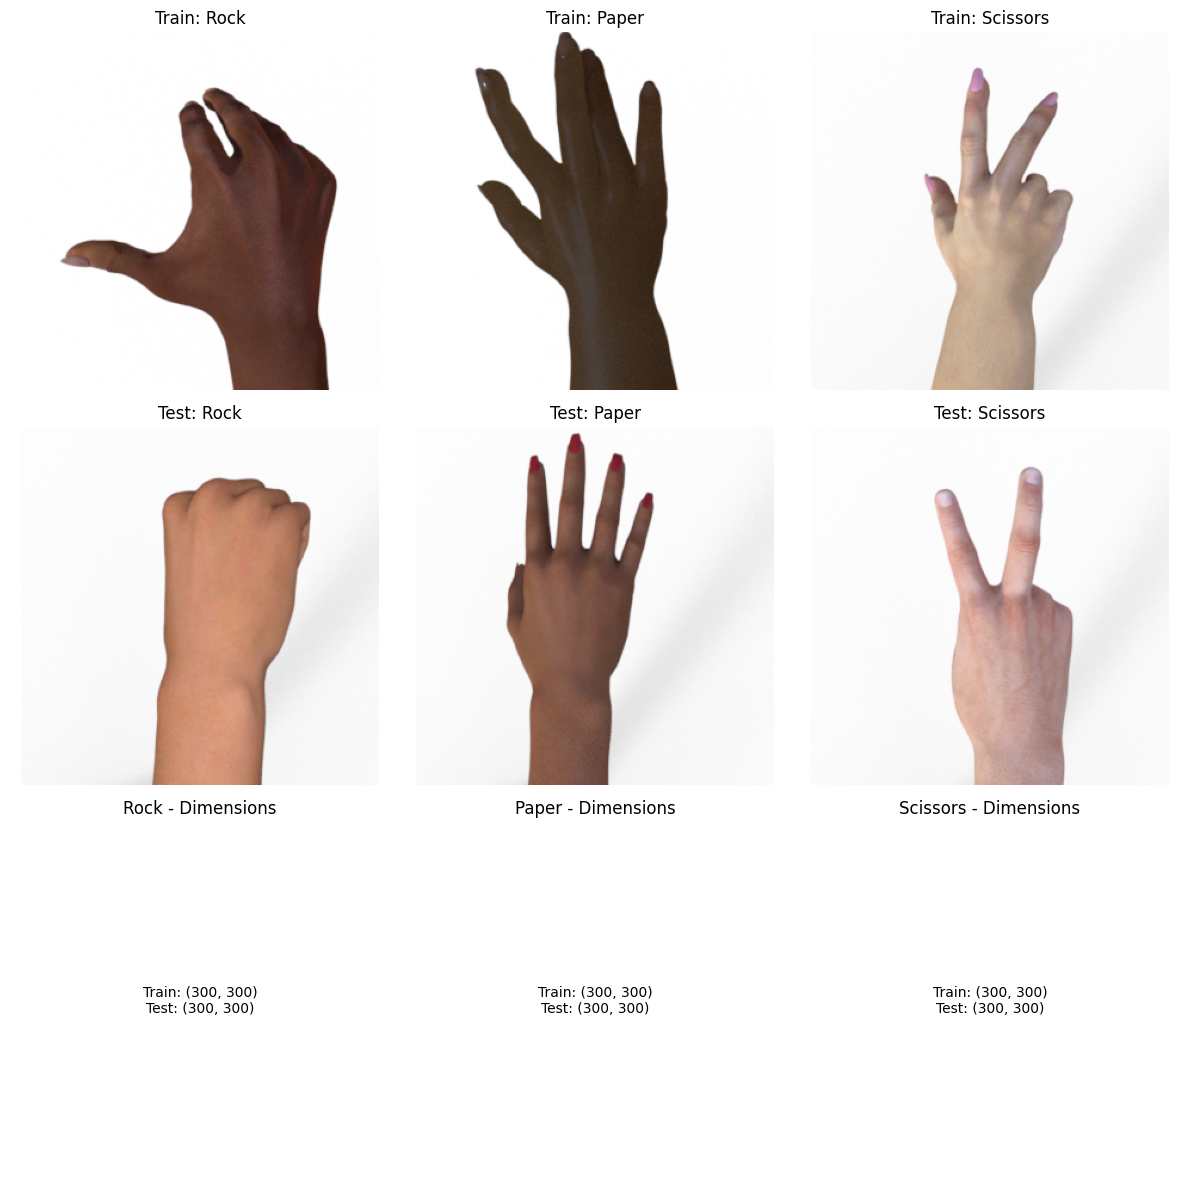

In [7]:
# Let's examine sample images from train and test
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
classes = ['rock', 'paper', 'scissors']

for i, class_name in enumerate(classes):
    # Training image
    train_path = f'Rock-Paper-Scissors/train/{class_name}'
    train_files = os.listdir(train_path)
    train_img = Image.open(os.path.join(train_path, train_files[0]))

    # Test image
    test_path = f'Rock-Paper-Scissors/test/{class_name}'
    test_files = os.listdir(test_path)
    test_img = Image.open(os.path.join(test_path, test_files[0]))

    # Display
    axes[0, i].imshow(train_img)
    axes[0, i].set_title(f'Train: {class_name.title()}')
    axes[0, i].axis('off')

    axes[1, i].imshow(test_img)
    axes[1, i].set_title(f'Test: {class_name.title()}')
    axes[1, i].axis('off')

    # Let's also check image dimensions
    axes[2, i].text(0.5, 0.5, f'Train: {train_img.size}\nTest: {test_img.size}',
                    ha='center', va='center', transform=axes[2, i].transAxes)
    axes[2, i].set_title(f'{class_name.title()} - Dimensions')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

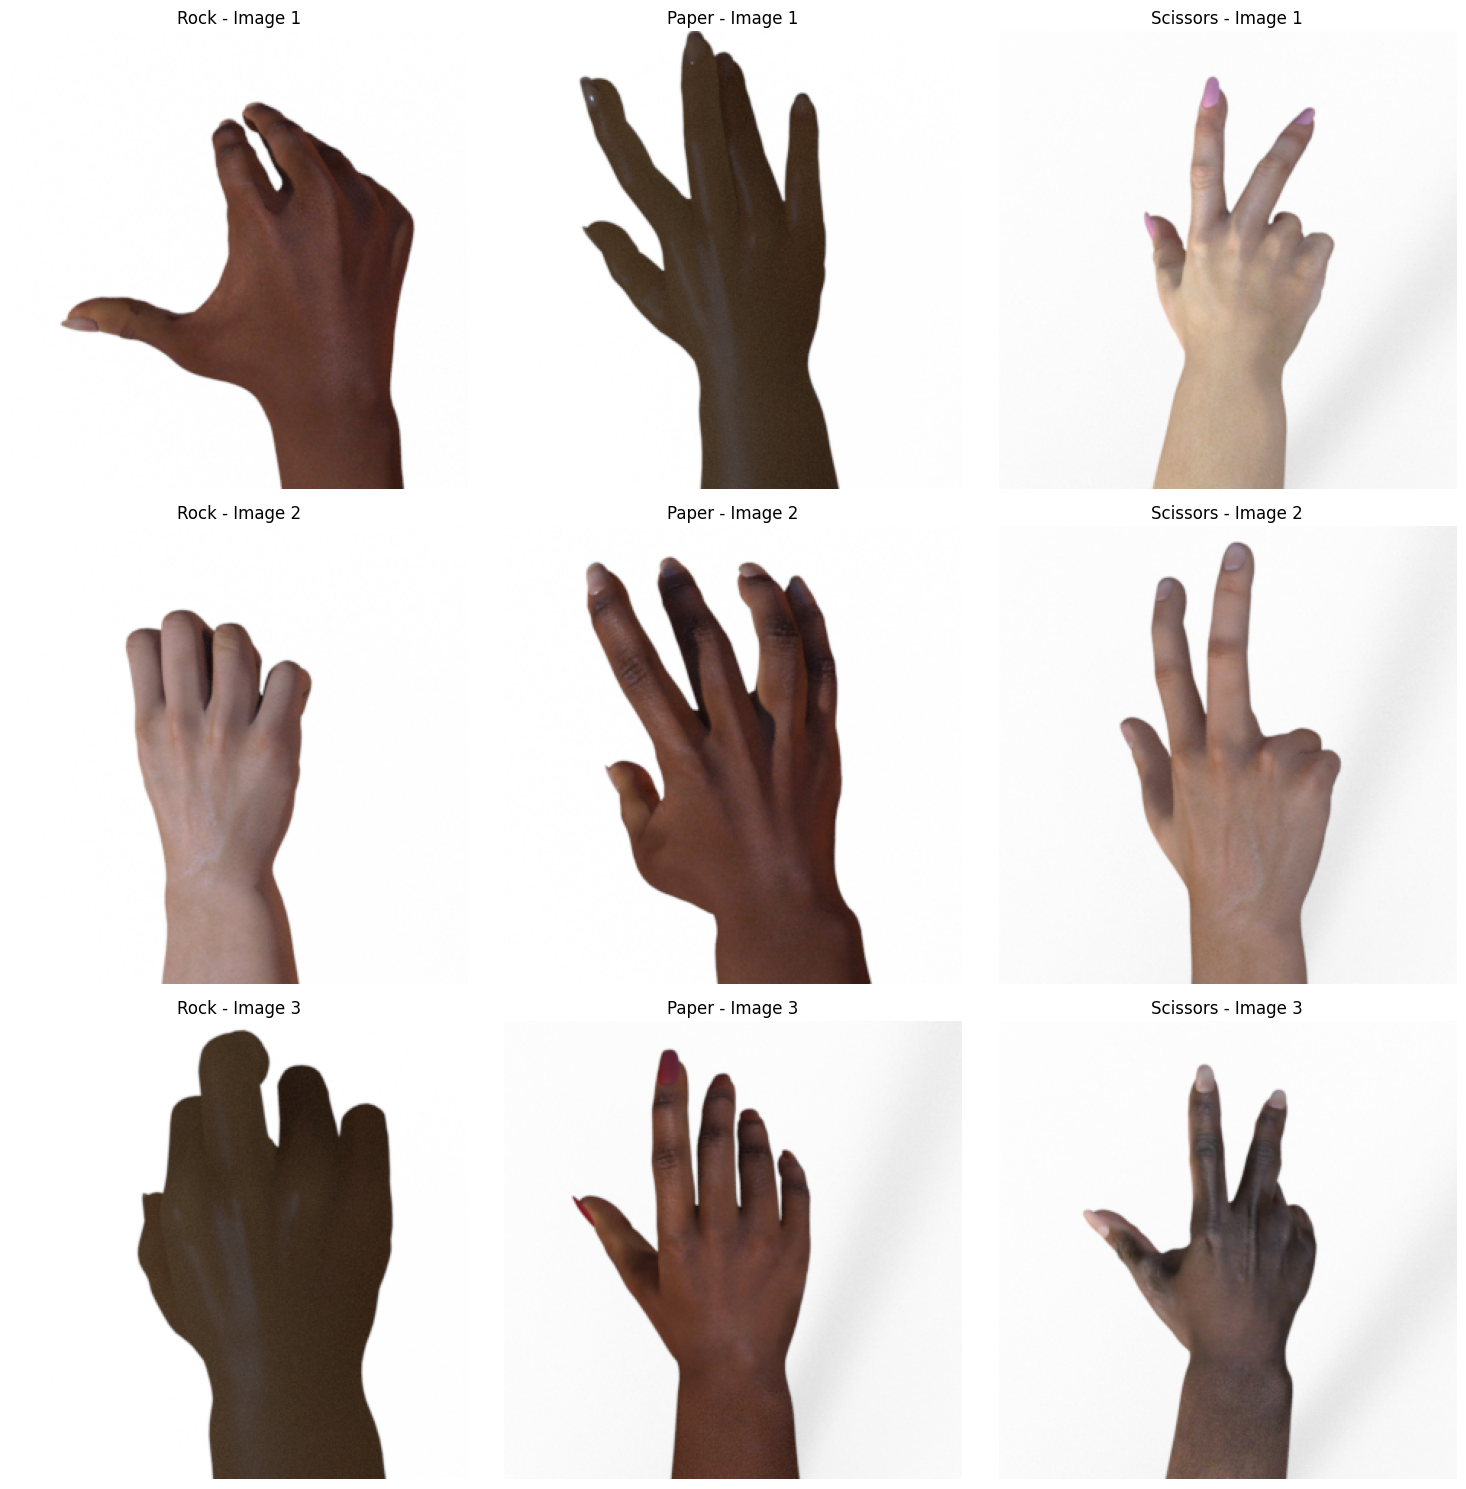

In [8]:
# Looking at first 3 images from each class
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for class_idx, class_name in enumerate(['rock', 'paper', 'scissors']):
    train_path = f'Rock-Paper-Scissors/train/{class_name}'
    train_files = os.listdir(train_path)

    for img_idx in range(3):  # Show first 3 images
        img = Image.open(os.path.join(train_path, train_files[img_idx]))
        axes[img_idx, class_idx].imshow(img)
        axes[img_idx, class_idx].set_title(f'{class_name.title()} - Image {img_idx + 1}')
        axes[img_idx, class_idx].axis('off')

plt.tight_layout()
plt.show()

Our dataset examples show the following highlights:
* Controlled environment: White backgrounds, no shadows
* Diverse representation: Multiple skin tones
* Images size - 300×300 pixels, not too small for loss of detail and not too large to cause memory issues

## Data Pre Processing

To create a robust and well functioning model, it is essential to pre process oru data. At the moment, our validation set contains only 33 images, which is not enough for model development, hyperparameter tuning, etc.

Our strategy:
1. Split the "train" folder (2,520 images) into:
    - Actual training: 2,016 images (80% of 2,520)
    - Validation: 504 images (20% of 2,520)
2. Keep the "test" folder (372 images) untouched until final evaluation

In [9]:
# Set seed for reproducibility
random.seed(42)

def create_balanced_split(data_dir, train_ratio=0.8):
    """
    Create balanced train/validation split maintaining class proportions
    """
    train_files = defaultdict(list)
    val_files = defaultdict(list)

    for class_name in ['rock', 'paper', 'scissors']:
        class_path = os.path.join(data_dir, class_name)
        all_files = os.listdir(class_path)

        # Shuffle files for this class
        random.shuffle(all_files)

        # Calculate split point
        n_train = int(len(all_files) * train_ratio)

        # Split this class
        train_files[class_name] = all_files[:n_train]
        val_files[class_name] = all_files[n_train:]

        print(f"{class_name}: {len(train_files[class_name])} train, {len(val_files[class_name])} val")

    return train_files, val_files

# Create our split
train_split, val_split = create_balanced_split('Rock-Paper-Scissors/train')

rock: 672 train, 168 val
paper: 672 train, 168 val
scissors: 672 train, 168 val


Now, we will create our DataSet class for Rock, Paper, Scissors.

In [10]:
class RockPaperScissorsDataset(Dataset):
    def __init__(self, file_dict, data_dir, transform=None):
        """
        Custom dataset for our Rock Paper Scissors images

        Args:
            file_dict: Dictionary with class names as keys, file lists as values
            data_dir: Path to the data directory
            transform: Optional transforms to apply to images
        """
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Create class to index mapping
        self.class_to_idx = {'paper': 0, 'rock': 1, 'scissors': 2}
        self.idx_to_class = {0: 'paper', 1: 'rock', 2: 'scissors'}

        # Build the dataset
        for class_name, file_list in file_dict.items():
            for filename in file_list:
                self.images.append(os.path.join(data_dir, class_name, filename))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)

        return image, label

## Data Transformation


We will now transform our data and make our images 224×224 in the interest of computational efficiency while still maintaining a high level of image detail. 224×224 is considered the standard image size for training Machine Learning models. We also add rotation and horizontal flip for **Data Augmentation** to add variety to our training dataset.

In [23]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=5),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Keep simple resize for validation/test sets
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Transforming our dataset based on above specifications.

In [24]:
# Create our datasets with separate transforms
train_dataset = RockPaperScissorsDataset(train_split, 'Rock-Paper-Scissors/train', transform=train_transform)
val_dataset = RockPaperScissorsDataset(val_split, 'Rock-Paper-Scissors/train', transform=val_transform)
test_dataset = ImageFolder(root = 'Rock-Paper-Scissors/test', transform=val_transform)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Let's verify our dataset is working
print(f"\nDataset verification:")
sample_image, sample_label = train_dataset[0]
print(f"Image tensor shape: {sample_image.shape}")
print(f"Label: {sample_label} (class: {train_dataset.idx_to_class[sample_label]})")

Training dataset size: 2016
Validation dataset size: 504

Dataset verification:
Image tensor shape: torch.Size([3, 224, 224])
Label: 1 (class: rock)


## Instantiating DataLoader

We are now setting up our DataLoader. We shuffle our dataset for training but not for validation. This is because we want to be testing on the data in the same order to make sure the model really is improving and didn't hit a fluke ordering of the dataset.

We choose batch size as 32 as it is the perfect balance for memory usage and stability. `num_workers=2` ensures 2 parallel processes loading data which makes it faster, and `pin_memory=True` optimizes CPU→GPU memory transfer.

In [25]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size= 32,
    shuffle=True,           # Shuffle training data
    num_workers=2,          # Parallel loading
    pin_memory=True         # Faster GPU transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size= 32,
    shuffle=False,          # Don't shuffle validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

## Model Architecture


We start by creating a simple CNN model with 4 convulational layers.

* We use `out_channels=16` to start to detect basic edges/textures and double the complexity as we move through the layers.

* `padding=1` with `kernel_size=3` - maintains spatial dimensions through conv layers.

* MaxPool2d layer with `kernel_size=2, stride=2` reduces the height and width dimensions of an image by half and reduces computational complexity. It is common practice to use as it makes the model less prone to overfitting and more robust to variations in the input.

* Fully connected layers: To determine the input size for the first FC layer, we need to calculate the size of the feature map after the last pooling layer. After 4 pools, the input size is 224/16 = 14.

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer
        self.fc1_input_features = 128 * 14 * 14
        self.fc1 = nn.Linear(self.fc1_input_features, 256)
        self.relu_fc1 = nn.ReLU()

        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)  # Shape: [batch_size, 128*14*14]

        # Fully connected classification
        x = self.fc1(x)          # [batch_size, 25088] -> [batch_size, 128]
        x = self.relu_fc1(x)     # Add nonlinearity

        x = self.fc2(x)          # [batch_size, 128] -> [batch_size, 3]

        return x

## Training Using the Model

We start with the Simple CNN model for training.

We use a basic PyTorch training loop, with standard built-in datasets, dataloaders and training loops.

In [27]:
class Train_model():
    def __init__(self, model, criterion, optimizer, device):
        self.model=model
        self.criterion=criterion #loss function
        self.optimizer=optimizer
        self.device=device

    def train_epoch(self, train_loader):
        model = self.model.train() # Model in training mode
        correct=0
        running_loss = 0.0
        progress_bar=tqdm(train_loader)
        for data in progress_bar:
            batch, labels = data  # separate inputs and labels (outputs)
            batch, labels = batch.to(self.device), labels.to(self.device)  # puts the data on the GPU

            self.optimizer.zero_grad() # clear the gradients in model parameters
            outputs = model(batch) # put data into model to predict
            loss = self.criterion(outputs, labels) # calculate loss between prediction and true labels
            loss.backward() # back propagation: pass the loss
            self.optimizer.step()  # iterate over all parameters in the model with requires_grad=True and update their weights.

            # compute training statistics
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(train_loader)
        avg_acc = correct / len(train_loader.dataset)

        return avg_loss, avg_acc

    def eval_model(self, val_loader):
        model=self.model.eval() # Model in validation mode
        with torch.no_grad():
            loss_val = 0.0
            correct_val = 0
            for data in tqdm(val_loader):
                batch, labels = data
                batch, labels = batch.to(self.device), labels.to(self.device)
                outputs = model(batch)
                loss = self.criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                loss_val += loss.item()
        avg_loss_val = loss_val / len(val_loader)
        avg_acc_val = correct_val /len(val_loader.dataset)

        return avg_loss_val, avg_acc_val

    def test(self, test_loader):
        correct = 0
        model=self.model.eval()
        with torch.no_grad(): # no gradient calculation
            for data in test_loader:
                batch, labels = data
                batch, labels = batch.to(self.device), labels.to(self.device)
                outputs = model(batch)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
        return ('Accuracy on the test images: %.2f %%' % (100 * correct / len(test_loader.dataset)))


## Training Setup


We use Adam as our optimizer, and Cross Entropy Loss, since this is a classification task. We set our learning rate to 0.001 after testing.

In [42]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Determine whether a GPU is available
criterion = nn.CrossEntropyLoss().to(device)

## SimpleCNN
simplecnn=SimpleCNN()
simplecnn.to(device) # send model to GPU
optimizer = optim.Adam(simplecnn.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

SimpleModel=Train_model(simplecnn, criterion, optimizer, device)

In [43]:
epoch=7
#acc log for graph
simp_acc_hist = []
simp_acc_hist_val =[]
for e in range(epoch):
  print(f'Epoch {e + 1}/{epoch}')
  print('-' * 10)
  simple_train_loss ,simple_train_acc= SimpleModel.train_epoch(train_loader)
  simp_acc_hist.append(simple_train_acc)
  print(f'Train loss {simple_train_loss} accuracy {simple_train_acc}')

  simple_val_loss, simple_val_acc = SimpleModel.eval_model(val_loader)
  simp_acc_hist_val.append(simple_val_acc)

  print(f'Val loss {simple_val_loss} accuracy {simple_val_acc}')
  print()

Epoch 1/7
----------


100%|██████████| 63/63 [00:22<00:00,  2.86it/s, loss=0.489]


Train loss 0.9624770856092847 accuracy 0.49007936507936506


100%|██████████| 16/16 [00:02<00:00,  7.46it/s]


Val loss 1.4344739106018096 accuracy 0.4444444444444444

Epoch 2/7
----------


100%|██████████| 63/63 [00:21<00:00,  3.00it/s, loss=0.294]


Train loss 0.3841831001733977 accuracy 0.8561507936507936


100%|██████████| 16/16 [00:02<00:00,  5.40it/s]


Val loss 0.2726188637861924 accuracy 0.8849206349206349

Epoch 3/7
----------


100%|██████████| 63/63 [00:21<00:00,  2.98it/s, loss=0.136]


Train loss 0.19303393210210498 accuracy 0.9360119047619048


100%|██████████| 16/16 [00:02<00:00,  6.21it/s]


Val loss 0.8851250248814608 accuracy 0.6567460317460317

Epoch 4/7
----------


100%|██████████| 63/63 [00:21<00:00,  2.96it/s, loss=0.0448]


Train loss 0.10876155955096085 accuracy 0.964781746031746


100%|██████████| 16/16 [00:02<00:00,  7.82it/s]


Val loss 0.13097130126607226 accuracy 0.9444444444444444

Epoch 5/7
----------


100%|██████████| 63/63 [00:22<00:00,  2.83it/s, loss=0.0846]


Train loss 0.0740340378371969 accuracy 0.9747023809523809


100%|██████████| 16/16 [00:02<00:00,  7.82it/s]


Val loss 0.044583210010614494 accuracy 0.9821428571428571

Epoch 6/7
----------


100%|██████████| 63/63 [00:21<00:00,  2.89it/s, loss=0.0142]


Train loss 0.07601961462632827 accuracy 0.9732142857142857


100%|██████████| 16/16 [00:02<00:00,  7.85it/s]


Val loss 0.05986165277454347 accuracy 0.9781746031746031

Epoch 7/7
----------


100%|██████████| 63/63 [00:21<00:00,  2.90it/s, loss=0.0232]


Train loss 0.06797792372249421 accuracy 0.9796626984126984


100%|██████████| 16/16 [00:02<00:00,  7.84it/s]

Val loss 0.06375094702025308 accuracy 0.9821428571428571



## Test Results

In [44]:
SimpleModel.test(test_loader)

'Accuracy on the test images: 97.04 %'

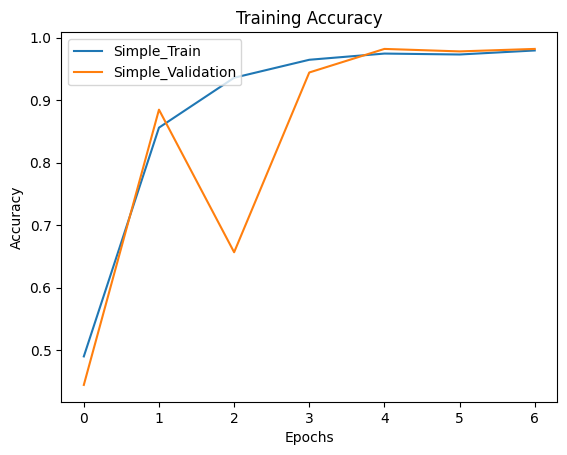

In [45]:
legend = ['Simple_Train', 'Simple_Validation']
plt.plot(simp_acc_hist)
plt.plot(simp_acc_hist_val)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

##Model Refinement

To improve our model performance, we will now build a Deeper CNN Model using ```nn.sequential``` for better performance.


Implementing  Learning Rate Scheduler and Early Stopping:

- ReduceLROnPlateau: This will automatically lower the learning rate when validation loss plateaus, helping the model fine-tune its weights.

- Early Stopping: This will save the best model (based on validation loss) and stop training when improvement ceases, preventing unnecessary epochs that lead to overfitting.

In [46]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()

        self.features = nn.Sequential(
            # Input: 3 channels (RGB)
            # Output: 16 channels, Feature Map size: 224 -> 112 (after MaxPool)
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),

            # Second Convolutional Block
            # Input: 16 channels
            # Output: 32 channels, Feature Map size: 112 -> 56 (after MaxPool)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),

            # Third Convolutional Block
            # Input: 32 channels
            # Output: 64 channels, Feature Map size: 56 -> 28 (after MaxPool)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),

            # Fourth Convolutional Block
            # Input: 64 channels
            # Output: 128 channels, Feature Map size: 28 -> 14 (after MaxPool)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25)
        )

        self.classifier = nn.Sequential(
            # First Fully Connected Layer
            nn.Linear(128 * 14 * 14, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.0),

            # Second Fully Connected Layer
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.0),

            # Output Layer
            nn.Linear(256, 3)
        )

    def forward(self, x):
        # Pass through the convolutional feature extraction layers
        x = self.features(x)
        x = x.view(x.size(0), -1)

        # Pass through the classifier (fully connected layers)
        x = self.classifier(x)
        return x


##Training for Deeper Model

In [47]:
## DeeperCNN
deepercnn=DeeperCNN()
deepercnn.to(device) # send model to GPU
optimizer = optim.Adam(deepercnn.parameters(), lr=0.001, weight_decay=1e-4)

DeeperModel=Train_model(deepercnn, criterion, optimizer, device)

In [48]:
epoch=9
#acc log for graph
deep_acc_hist = []
deep_acc_hist_val =[]
for e in range(epoch):
  print(f'Epoch {e + 1}/{epoch}')
  print('-' * 10)
  deeper_train_loss ,deeper_train_acc= DeeperModel.train_epoch(train_loader)
  deep_acc_hist.append(deeper_train_acc)
  print(f'Train loss {deeper_train_loss} accuracy {deeper_train_acc}')

  deeper_val_loss, deeper_val_acc = DeeperModel.eval_model(val_loader)
  deep_acc_hist_val.append(deeper_val_acc)
  print(f'Val loss {deeper_val_loss} accuracy {deeper_val_acc}')
  print()

Epoch 1/9
----------


100%|██████████| 63/63 [00:20<00:00,  3.11it/s, loss=0.901]


Train loss 0.9623831747070192 accuracy 0.527281746031746


100%|██████████| 16/16 [00:02<00:00,  7.47it/s]


Val loss 0.3241308191791177 accuracy 0.9444444444444444

Epoch 2/9
----------


100%|██████████| 63/63 [00:22<00:00,  2.83it/s, loss=0.441]


Train loss 0.5313702741312603 accuracy 0.7787698412698413


100%|██████████| 16/16 [00:02<00:00,  7.88it/s]


Val loss 0.3370982158521656 accuracy 0.8452380952380952

Epoch 3/9
----------


100%|██████████| 63/63 [00:21<00:00,  2.89it/s, loss=0.33]


Train loss 0.3279137991013981 accuracy 0.8670634920634921


100%|██████████| 16/16 [00:02<00:00,  7.91it/s]


Val loss 0.1252795383115881 accuracy 0.9583333333333334

Epoch 4/9
----------


100%|██████████| 63/63 [00:21<00:00,  2.91it/s, loss=0.144]


Train loss 0.2401107471022341 accuracy 0.9107142857142857


100%|██████████| 16/16 [00:02<00:00,  7.76it/s]


Val loss 0.04261368734296411 accuracy 0.9880952380952381

Epoch 5/9
----------


100%|██████████| 63/63 [00:21<00:00,  2.95it/s, loss=0.0823]


Train loss 0.19914935334097772 accuracy 0.9310515873015873


100%|██████████| 16/16 [00:02<00:00,  7.86it/s]


Val loss 0.021974271650833543 accuracy 0.9920634920634921

Epoch 6/9
----------


100%|██████████| 63/63 [00:20<00:00,  3.02it/s, loss=0.31]


Train loss 0.16331675678255067 accuracy 0.9399801587301587


100%|██████████| 16/16 [00:02<00:00,  7.28it/s]


Val loss 0.023717311214568326 accuracy 0.9920634920634921

Epoch 7/9
----------


100%|██████████| 63/63 [00:20<00:00,  3.03it/s, loss=0.2]


Train loss 0.15126714429685048 accuracy 0.9444444444444444


100%|██████████| 16/16 [00:03<00:00,  5.30it/s]


Val loss 0.011421518131101038 accuracy 1.0

Epoch 8/9
----------


100%|██████████| 63/63 [00:20<00:00,  3.04it/s, loss=0.0567]


Train loss 0.11506851653139742 accuracy 0.9632936507936508


100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Val loss 0.01693460645765299 accuracy 0.996031746031746

Epoch 9/9
----------


100%|██████████| 63/63 [00:21<00:00,  2.95it/s, loss=0.38]


Train loss 0.10689774795716243 accuracy 0.9632936507936508


100%|██████████| 16/16 [00:02<00:00,  7.82it/s]

Val loss 0.054764206395702786 accuracy 0.9742063492063492



In [49]:
DeeperModel.test(test_loader)

'Accuracy on the test images: 91.40 %'

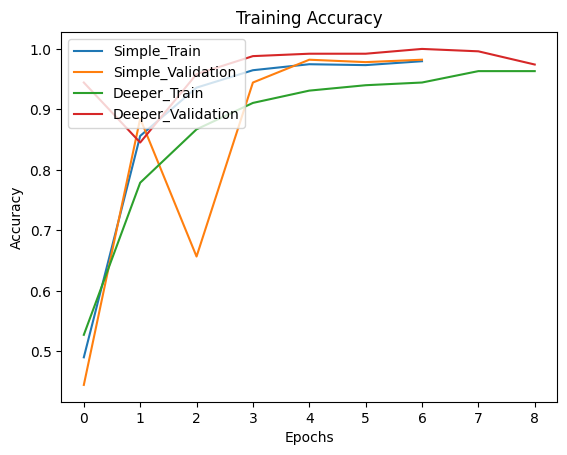

In [50]:
legend = ['Simple_Train', 'Simple_Validation', 'Deeper_Train', 'Deeper_Validation']
plt.plot(simp_acc_hist)
plt.plot(simp_acc_hist_val)
plt.plot(deep_acc_hist)
plt.plot(deep_acc_hist_val)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

In [54]:
# Fixed prediction code
def test_predictions(model, test_loader, device, num_samples=8):
    """Display predictions vs true labels"""
    model.eval()

    # Get one batch from test loader
    data_iter = iter(test_loader)
    test_batch, test_labels = next(data_iter)

    with torch.no_grad():
        outputs = model(test_batch.to(device))
        _, predicted = torch.max(outputs, 1)

    # Class names mapping
    class_names = ['paper', 'rock', 'scissors']  # ImageFolder sorts alphabetically

    print("Prediction Results:")
    print("-" * 50)
    for i in range(min(num_samples, len(test_labels))):
        true_label = class_names[test_labels[i]]
        pred_label = class_names[predicted[i]]
        confidence = torch.softmax(outputs[i], dim=0)[predicted[i]] * 100

        status = "✅" if true_label == pred_label else "❌"
        print(f"{status} True: {true_label:8} | Pred: {pred_label:8} | Confidence: {confidence:.1f}%")

# Usage
print("Simple Model")
test_predictions(SimpleModel.model, test_loader, device)
print("-"*50)

print("Deeper Model")
test_predictions(DeeperModel.model, test_loader, device)

Simple Model
Prediction Results:
--------------------------------------------------
✅ True: paper    | Pred: paper    | Confidence: 87.0%
✅ True: paper    | Pred: paper    | Confidence: 88.7%
✅ True: paper    | Pred: paper    | Confidence: 91.7%
✅ True: paper    | Pred: paper    | Confidence: 95.1%
✅ True: paper    | Pred: paper    | Confidence: 97.6%
✅ True: paper    | Pred: paper    | Confidence: 98.5%
✅ True: paper    | Pred: paper    | Confidence: 99.7%
✅ True: paper    | Pred: paper    | Confidence: 100.0%
--------------------------------------------------
Deeper Model
Prediction Results:
--------------------------------------------------
✅ True: paper    | Pred: paper    | Confidence: 53.4%
✅ True: paper    | Pred: paper    | Confidence: 52.6%
✅ True: paper    | Pred: paper    | Confidence: 60.5%
✅ True: paper    | Pred: paper    | Confidence: 76.2%
✅ True: paper    | Pred: paper    | Confidence: 87.3%
✅ True: paper    | Pred: paper    | Confidence: 94.4%
✅ True: paper    | Pred: